## MDAnalysis Script for Replica Exchange Trajectory Analysis in a Jupyter Notebook

This script provides functions to load, align, and analyze multi-frame PDB
files from a Replica Exchange Molecular Dynamics (REMD) simulation.

It calculates:
1. RMSD (Root Mean Square Deviation) against a reference.
2. RMSF (Root Mean Square Fluctuation) per residue.
3. Radius of Gyration (Rg).
4. Secondary Structure Content (Q3) - A useful metric for folding state.
5. Minimum Distances (e.g., between N-terminus and C-terminus) - To track folding/unfolding.

Assumptions:
- All PDB files contain the same protein structure/sequence.
- The reference PDB file (e.g., 'native_structure.pdb') represents the desired folded state.

In [40]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os
from MDAnalysis.analysis import rms, density, distances
from MDAnalysis.analysis.dssp import DSSP

In [ ]:
# --- CONFIGURATION ---
# Define the file paths for your analysis
no_structures = 12

REFERENCE_FILE = "BB-AA.pdb" # The all-atom backbone PDB of your target reference structure
REPLICAS = [f"aa_pdbs/replica_{i}_AA.pdb" for i in range(1, no_structures+1)]  # List of replica files (trajectories)
STATES = [f"aa_pdbs/state_{i}_AA.pdb" for i in range(1, no_structures+1)]    # List of state files (trajectories)
TRAJECTORY_FILES = STATES # Combine all files to process them if desired. In this case we are only interested in States

# Selection string for alignment and analysis (e.g., 'protein' or 'protein and backbone')
# 'protein and name CA' is often a good choice for RMSD/RMSF in folding
# 'protein and backbone' is a standard choice for alignment
SELECTION = "protein and name CA"

In [42]:
# --- HELPER FUNCTIONS ---

def load_and_align_trajectory(trajectory_file, reference_file, selection):
    """Loads a trajectory and aligns all frames to the reference structure."""
    if not os.path.exists(trajectory_file):
        print(f"Warning: File not found: {trajectory_file}. Skipping.")
        return None

    # Load the reference and the trajectory
    ref = mda.Universe(reference_file)
    mobile = mda.Universe(trajectory_file)

    # Check for empty universe after loading (e.g., if PDB is malformed)
    if not mobile.select_atoms("all"):
        print(f"Error: Could not load atoms from {trajectory_file}. Skipping.")
        return None

    # Perform alignment on the selected atoms
    aligner = rms.RMSD(
        mobile,
        ref,
        select=selection,
        groupselections=[selection, selection] # Both groups should use the same selection
    )
    aligner.run()

    # The mobile Universe is now implicitly aligned via the results object
    return mobile, aligner.results.rmsd, ref, mobile

def calculate_all_metrics(u_aligned, selection, file_tag):
    """Calculates all defined metrics for a given MDAnalysis Universe."""
    data = {}
    n_frames = len(u_aligned.trajectory)
    print(f"Processing {file_tag} with {n_frames} frames...")

    # 1. Radius of Gyration (Rg)
    # Rg is a measure of compactness. Lower Rg usually means more compact/folded.
    protein_atoms = u_aligned.select_atoms('protein')
    rg_values = [protein_atoms.radius_of_gyration() for ts in u_aligned.trajectory]
    data['Rg'] = rg_values

    # Reset trajectory to start for next analysis
    u_aligned.trajectory.rewind()

    # 2. RMSF (Root Mean Square Fluctuation)
    # RMSF measures the average distance a residue is from a reference position.
    # High RMSF indicates high flexibility, often observed in unfolded or loop regions.
    R = rms.RMSF(protein_atoms, select=selection).run()
    # The output is per-atom, we usually look at per-residue averages or C-alpha only.
    rmsf_data = R.results.rmsf
    # Get the residue IDs for plotting
    resids = protein_atoms.resids
    data['RMSF_Per_Atom'] = pd.DataFrame({'Residue_ID': resids, 'RMSF': rmsf_data})

    u_aligned.trajectory.rewind()

    try:
        # 1. Select the entire protein
        protein_atoms = u_aligned.select_atoms("protein")
        
        # 2. Identify the first and last residue IDs
        # This helps in trimming the potentially incomplete termini
        first_res = protein_atoms.residues[0].resid
        last_res = protein_atoms.residues[-1].resid
    
        # 3. Create a selection that excludes the first and last residue.
        # We select all protein residues *except* the termini, which are often incomplete.
        # This selection guarantees full backbone atoms for all included residues.
        # Use 'protein and resid <last_res and resid >first_res' for non-cyclic or
        # more safely: 'protein and not (resnum %s or resnum %s)'
        
        # The selection below targets the full set of N, CA, C, O atoms
        # excluding the first and last residue numbers.
        residue_range_selection = f"protein and not (resnum {first_res} or resnum {last_res}) and (name N or name CA or name C or name O)"
        backbone_atoms = u_aligned.select_atoms(residue_range_selection)
        
        # Optional: If you suspect only one terminus is incomplete, you can try:
        # backbone_atoms = u_aligned.select_atoms(f"protein and resnum > {first_res} and (name N or name CA or name C or name O)")
        # OR
        # backbone_atoms = u_aligned.select_atoms(f"protein and resnum < {last_res} and (name N or name CA or name C or name O)")
    
        # Re-check the counts for the refined selection (should be equal now)
        n_residues = len(backbone_atoms.residues)
        n_n = len(backbone_atoms.select_atoms("name N"))
        n_ca = len(backbone_atoms.select_atoms("name CA"))
        
        if n_n != n_ca or n_n != n_residues:
            # If trimming the termini fails, throw an error with the current counts
            raise ValueError(
                f"Termini trimming failed. Current counts: N={n_n}, CA={n_ca}, C={len(backbone_atoms.select_atoms('name C'))}, O={len(backbone_atoms.select_atoms('name O'))}"
            )
    
        # 4. Pass the cleaned AtomGroup to DSSP
        print(f"Running DSSP on {n_residues} internal residues.")
        dssp_analysis = DSSP(backbone_atoms).run()
        
        # DSSP codes for stable structure: 'H', 'E', 'G'
        ss_codes_to_count = ['H', 'E', 'G']
    
        q3_values = []
        
        # The number of residues is now based on the selected AtomGroup
        # n_residues_for_q3 = dssp_analysis.residues.n_residues 
        n_residues_for_q3 = n_residues
    
        # Calculate Q3 Content
        for frame_ss_array in dssp_analysis.results.dssp:
            stable_ss_count = np.sum(np.isin(frame_ss_array, ss_codes_to_count))
            q3_values.append(stable_ss_count / n_residues_for_q3 if n_residues_for_q3 > 0 else 0)
    
        data['Q3_Content'] = q3_values
        
    except ValueError as ve:
        print(f"Error calculating DSSP/Q3: {ve}. Skipping Q3 calculation.")
        data['Q3_Content'] = []
        
    except Exception as e:
        print(f"Error calculating DSSP/Q3: {e}. Skipping Q3 calculation.")
        data['Q3_Content'] = []
        
    u_aligned.trajectory.rewind()

    # 4. End-to-End Distance
    # A simple proxy for structure extension/unfolding.
    try:
        n_terminus = u_aligned.select_atoms(f'name N and resnum {first_res + 1}')
        c_terminus = u_aligned.select_atoms(f'name CA and resnum  {last_res - 1}')
        if n_terminus and c_terminus:
            end_to_end_dist = [
                distances.distance_array(n_terminus.positions, c_terminus.positions)[0][0]
                for ts in u_aligned.trajectory
            ]
            data['End_to_End_Distance'] = end_to_end_dist
        else:
             print("Warning: Could not select N/C termini for End-to-End distance calculation.")
    except Exception as e:
        print(f"Error calculating End-to-End distance: {e}")
        pass # Skip this metric if selection fails

    # Align the final trajectory state back to the beginning state for consistency in the Universe object
    u_aligned.trajectory.rewind()
    return data

In [43]:
"""Main function to run the full analysis pipeline."""
# Ensure the reference file exists before proceeding
if not os.path.exists(REFERENCE_FILE):
    print(f"Error: Reference file not found: {REFERENCE_FILE}. Please create a placeholder or check the path.")

In [44]:
# List to hold all results
all_rmsd_results = {}
all_structural_metrics = {}
all_rmsf_per_atom = {}

print(f"Starting analysis with Reference: {REFERENCE_FILE}...")

for file_path in TRAJECTORY_FILES:
    file_tag = os.path.basename(file_path).replace(".pdb", "")
    print(f"\n--- Analyzing: {file_tag} ---")

    # Step 1: Load and Align
    u_aligned, rmsd_array, ref_u, traj_u = load_and_align_trajectory(file_path, REFERENCE_FILE, SELECTION)
    if u_aligned is None:
        continue
     # = result

    # Store RMSD results
    all_rmsd_results[file_tag] = pd.DataFrame(rmsd_array, columns=['Frame', 'Time', 'RMSD', 'A', 'B'])

    # Step 2: Calculate Structural Metrics (Rg, Q3, Distance)
    structural_data = calculate_all_metrics(u_aligned, SELECTION, file_tag)
    all_structural_metrics[file_tag] = {
        'Rg': structural_data.get('Rg', []),
        'Q3_Content': structural_data.get('Q3_Content', []),
        'End_to_End_Distance': structural_data.get('End_to_End_Distance', []),
    }
    # Store RMSF separately as it's residue-based, not frame-based
    all_rmsf_per_atom[file_tag] = structural_data.get('RMSF_Per_Atom')


print("\n--- Analysis Complete ---")

Starting analysis with Reference: PRO403-BB-AA.pdb...

--- Analyzing: state_1_AA ---


/Users/clairenoble/mambaforge/envs/jupyter/lib/python3.12/site-packages/MDAnalysis/analysis/base.py:562: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[idx] = ts.time
/Users/clairenoble/mambaforge/envs/jupyter/lib/python3.12/site-packages/MDAnalysis/coordinates/base.py:759: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.time


Processing state_1_AA with 200 frames...
Running DSSP on 390 internal residues.

--- Analyzing: state_2_AA ---
Processing state_2_AA with 200 frames...
Running DSSP on 390 internal residues.

--- Analyzing: state_3_AA ---
Processing state_3_AA with 200 frames...
Running DSSP on 390 internal residues.

--- Analyzing: state_4_AA ---
Processing state_4_AA with 200 frames...
Running DSSP on 390 internal residues.

--- Analyzing: state_5_AA ---
Processing state_5_AA with 200 frames...
Running DSSP on 390 internal residues.

--- Analyzing: state_6_AA ---
Processing state_6_AA with 200 frames...
Running DSSP on 390 internal residues.

--- Analyzing: state_7_AA ---
Processing state_7_AA with 200 frames...
Running DSSP on 390 internal residues.

--- Analyzing: state_8_AA ---
Processing state_8_AA with 200 frames...
Running DSSP on 390 internal residues.

--- Analyzing: state_9_AA ---
Processing state_9_AA with 200 frames...
Running DSSP on 390 internal residues.

--- Analyzing: state_10_AA ---


In [45]:
rg_dict = {}
q3_dict = {}
ee_dict = {}
rmsf_df_dict = {}


for file_path in TRAJECTORY_FILES:
    file_tag = os.path.basename(file_path).replace(".pdb", "")

    rg_dict[file_tag] = pd.DataFrame(all_structural_metrics[file_tag].get('Rg', []), columns = ['Rg'])
    q3_dict[file_tag]=pd.DataFrame(all_structural_metrics[file_tag].get('Q3_Content', []), columns = ['Q3'])
    ee_dict[file_tag]=pd.DataFrame(all_structural_metrics[file_tag].get('End_to_End_Distance', []), columns = ['End_to_End_Distance'])


In [46]:
structural_data['RMSF_Per_Atom']

,Residue_ID,RMSF
0,1,23.688150
1,1,23.258789
2,1,23.297387
3,1,23.930501
4,2,22.960833
...,...,...
2284,392,14.432223
2285,392,14.430165
2286,392,14.113142
2287,392,14.241572



Generating Plots (Run these cells in your notebook):
--------------------------------------------------


<>:13: SyntaxWarning: invalid escape sequence '\A'
<>:53: SyntaxWarning: invalid escape sequence '\A'
<>:13: SyntaxWarning: invalid escape sequence '\A'
<>:53: SyntaxWarning: invalid escape sequence '\A'
/var/folders/hx/mp69d5kd7hlb2v_83zj81h0m0000gn/T/ipykernel_47962/1594229735.py:13: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('RMSD ($\AA$)')
/var/folders/hx/mp69d5kd7hlb2v_83zj81h0m0000gn/T/ipykernel_47962/1594229735.py:53: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('RMSD ($\AA$)')
/var/folders/hx/mp69d5kd7hlb2v_83zj81h0m0000gn/T/ipykernel_47962/1594229735.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


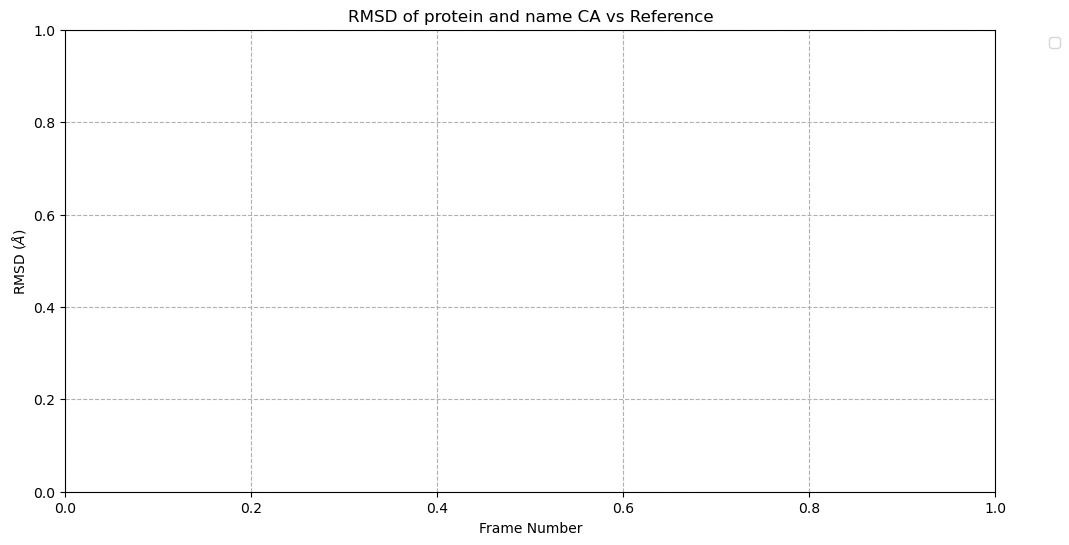

/var/folders/hx/mp69d5kd7hlb2v_83zj81h0m0000gn/T/ipykernel_47962/1594229735.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('coolwarm')


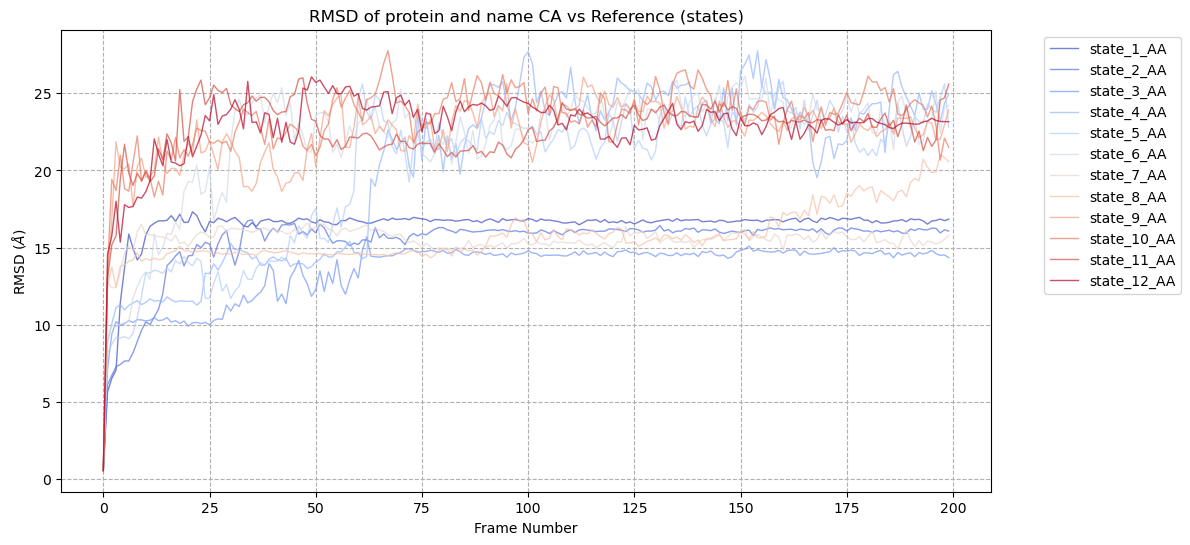

In [47]:
# --- Step 3: Plotting (For Jupyter Notebook Display) ---

print("\nGenerating Plots (Run these cells in your notebook):")
print("--------------------------------------------------")

# A. Plot RMSD Timeseries for all trajectories
plt.figure(figsize=(12, 6))
for tag, df in all_rmsd_results.items():
    if tag.startswith('replica'):
        plt.plot(df['Frame'], df['RMSD'], label=tag, alpha=0.7, linewidth=1)
plt.title(f'RMSD of {SELECTION} vs Reference')
plt.xlabel('Frame Number')
plt.ylabel('RMSD ($\AA$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--')
plt.show()

# --- Setup for Colormap ---
# 1. Filter the items you intend to plot to get the count
plot_tags = [tag for tag in all_rmsd_results.keys() if tag.startswith('state')]
num_lines = len(plot_tags)

# 2. Select the colormap
colormap = cm.get_cmap('coolwarm') 

# 3. Create a list of colors by sampling the colormap
# The np.linspace or similar sampling is often used, but here we can just 
# iterate from 0 to 1 with steps of 1/num_lines.
colors = [colormap(i / (num_lines - 1)) for i in range(num_lines)] 

# --- Plotting Script ---
plt.figure(figsize=(12, 6))

# Use an index to select the color for each line
line_index = 0
for tag, df in all_rmsd_results.items():
    if tag.startswith('state'):
        # Get the color for the current line
        current_color = colors[line_index]

        
        # Pass the assigned color to the plot function
        plt.plot(df['Frame'], df['RMSD'], 
                 label=tag, 
                 alpha=0.7, 
                 linewidth=1,
                 color=current_color)
                 
        line_index += 1 # Move to the next color for the next line

plt.title(f'RMSD of {SELECTION} vs Reference (states)')
plt.xlabel('Frame Number')
plt.ylabel('RMSD ($\AA$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--')
plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\A'
<>:33: SyntaxWarning: invalid escape sequence '\A'
<>:8: SyntaxWarning: invalid escape sequence '\A'
<>:33: SyntaxWarning: invalid escape sequence '\A'
/var/folders/hx/mp69d5kd7hlb2v_83zj81h0m0000gn/T/ipykernel_47962/1205091750.py:8: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('Rg ($\AA$)')
/var/folders/hx/mp69d5kd7hlb2v_83zj81h0m0000gn/T/ipykernel_47962/1205091750.py:33: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('RMSD ($\AA$)')
/var/folders/hx/mp69d5kd7hlb2v_83zj81h0m0000gn/T/ipykernel_47962/1205091750.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


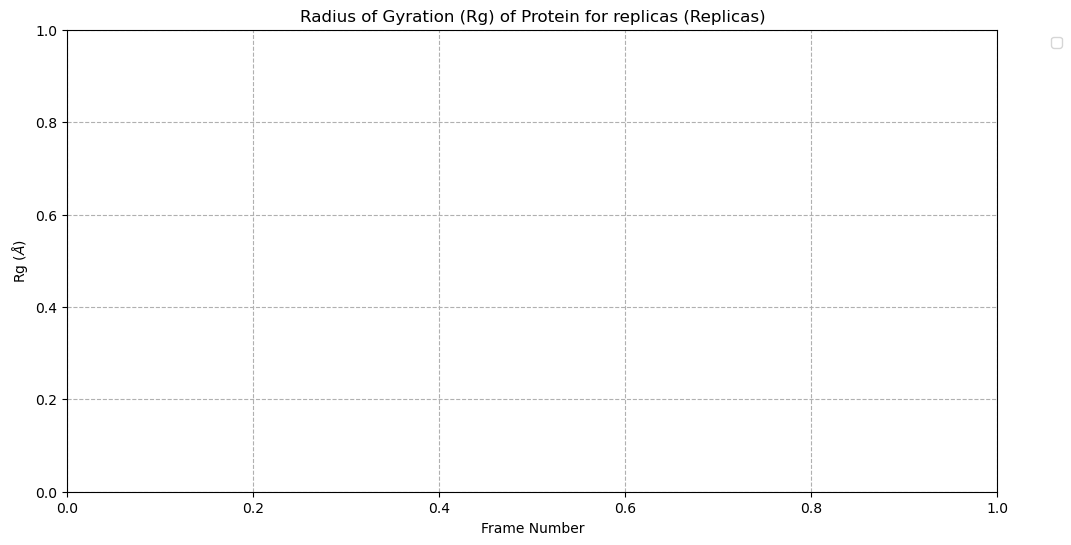

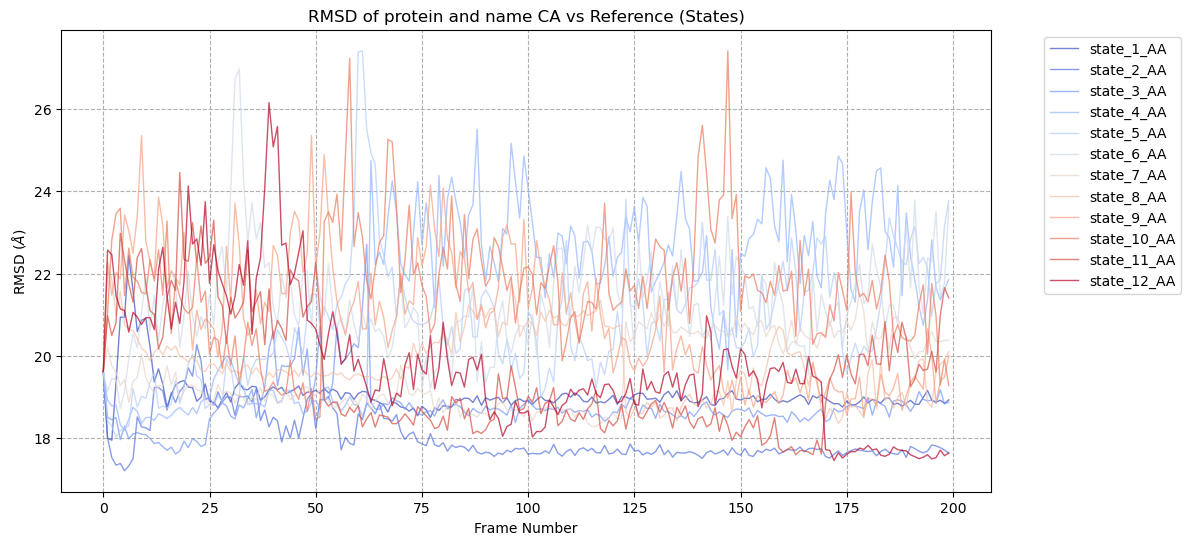

In [48]:
# B. Plot Radius of Gyration (Rg) Timeseries
plt.figure(figsize=(12, 6))
for tag, df in rg_dict.items():
    if tag.startswith('replica'):
        plt.plot(df.index, df['Rg'], label=tag, alpha=0.7, linewidth=1)
plt.title(f'Radius of Gyration (Rg) of Protein for replicas (Replicas)')
plt.xlabel('Frame Number')
plt.ylabel('Rg ($\AA$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--')
plt.show()

plt.figure(figsize=(12, 6))

# Use an index to select the color for each line
line_index = 0
for tag, df in rg_dict.items():
    if tag.startswith('state'):
        # Get the color for the current line
        current_color = colors[line_index]
        
        # Pass the assigned color to the plot function
        plt.plot(df.index, df['Rg'],
                 label=tag, 
                 alpha=0.7, 
                 linewidth=1,
                 color=current_color)
                 
        line_index += 1 # Move to the next color for the next line

plt.title(f'RMSD of {SELECTION} vs Reference (States)')
plt.xlabel('Frame Number')
plt.ylabel('RMSD ($\AA$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--')
plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\A'
<>:36: SyntaxWarning: invalid escape sequence '\A'
<>:8: SyntaxWarning: invalid escape sequence '\A'
<>:36: SyntaxWarning: invalid escape sequence '\A'
/var/folders/hx/mp69d5kd7hlb2v_83zj81h0m0000gn/T/ipykernel_47962/1118842466.py:8: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('End_to_End_Distance ($\AA$)')
/var/folders/hx/mp69d5kd7hlb2v_83zj81h0m0000gn/T/ipykernel_47962/1118842466.py:36: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('End_to_End_Distance ($\AA$)')
/var/folders/hx/mp69d5kd7hlb2v_83zj81h0m0000gn/T/ipykernel_47962/1118842466.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


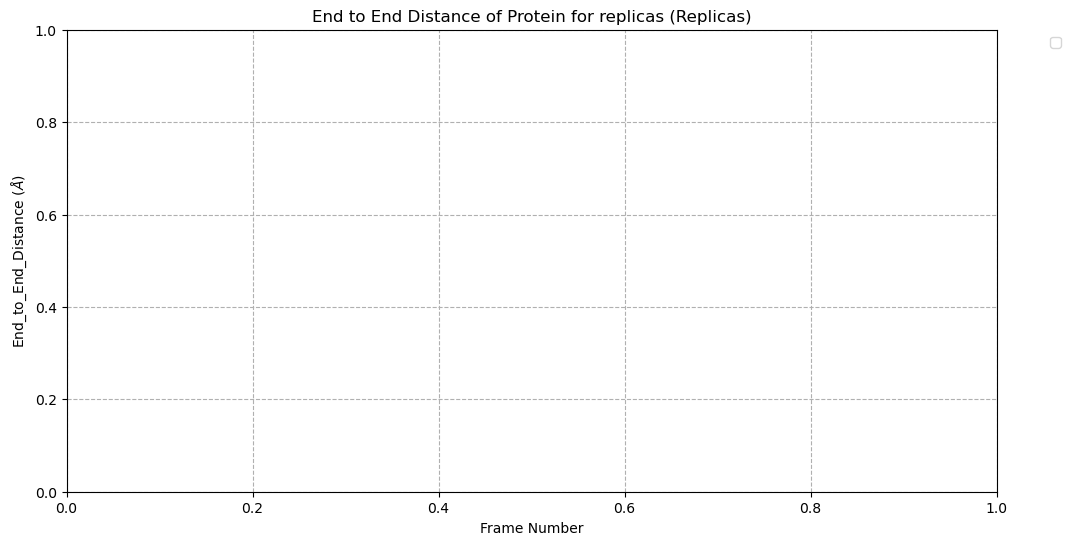

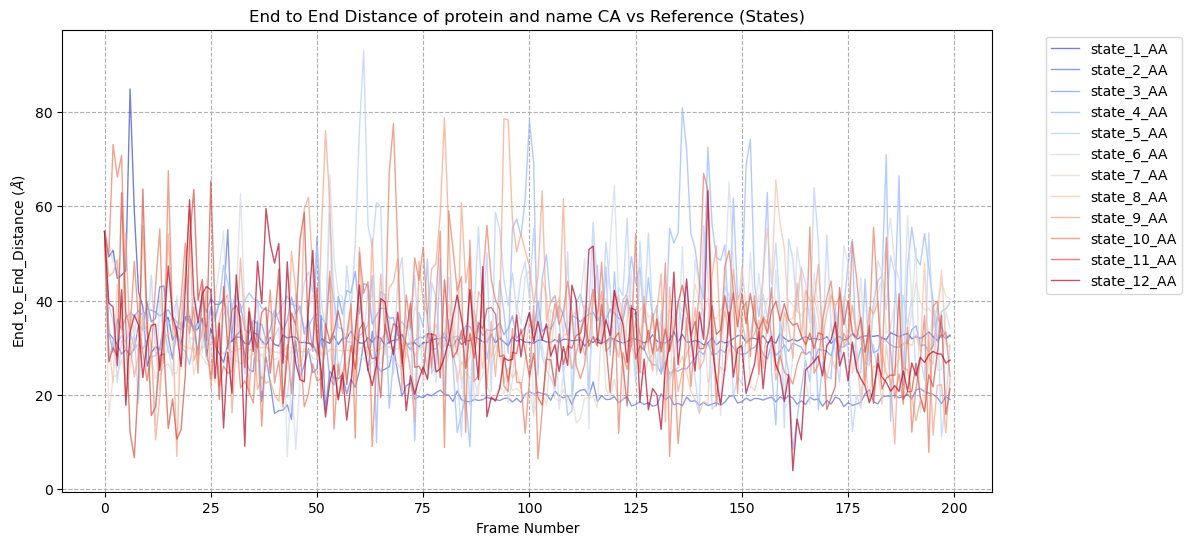

In [49]:
# B. Plot Radius of Gyration (Rg) Timeseries
plt.figure(figsize=(12, 6))
for tag, df in ee_dict.items():
    if tag.startswith('replica'):
        plt.plot(df.index, df['End_to_End_Distance'], label=tag, alpha=0.7, linewidth=1)
plt.title(f'End to End Distance of Protein for replicas (Replicas)')
plt.xlabel('Frame Number')
plt.ylabel('End_to_End_Distance ($\AA$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--')
plt.show()

plt.figure(figsize=(12, 6))

# Use an index to select the color for each line
line_index = 0
for tag, df in ee_dict.items():
    if tag.startswith('state'):
        # Get the color for the current line
        current_color = colors[line_index]
        
        # Only plot the first few frames for clarity, or plot all if frames < 1000
        n_points = min(1000, len(df))
        
        # Pass the assigned color to the plot function
        plt.plot(df.index, df['End_to_End_Distance'],
                 label=tag, 
                 alpha=0.7, 
                 linewidth=1,
                 color=current_color)
                 
        line_index += 1 # Move to the next color for the next line

plt.title(f'End to End Distance of {SELECTION} vs Reference (States)')
plt.xlabel('Frame Number')
plt.ylabel('End_to_End_Distance ($\AA$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--')
plt.show()

['aa_pdbs/replica_1_AA', 'aa_pdbs/replica_12_AA', 'aa_pdbs/state_1_AA', 'aa_pdbs/state_12_AA']
df missing, tag is replica_1_AA
df missing, tag is replica_12_AA


<>:25: SyntaxWarning: invalid escape sequence '\A'
<>:25: SyntaxWarning: invalid escape sequence '\A'
/var/folders/hx/mp69d5kd7hlb2v_83zj81h0m0000gn/T/ipykernel_47962/2844481891.py:25: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('RMSF ($\AA$)')


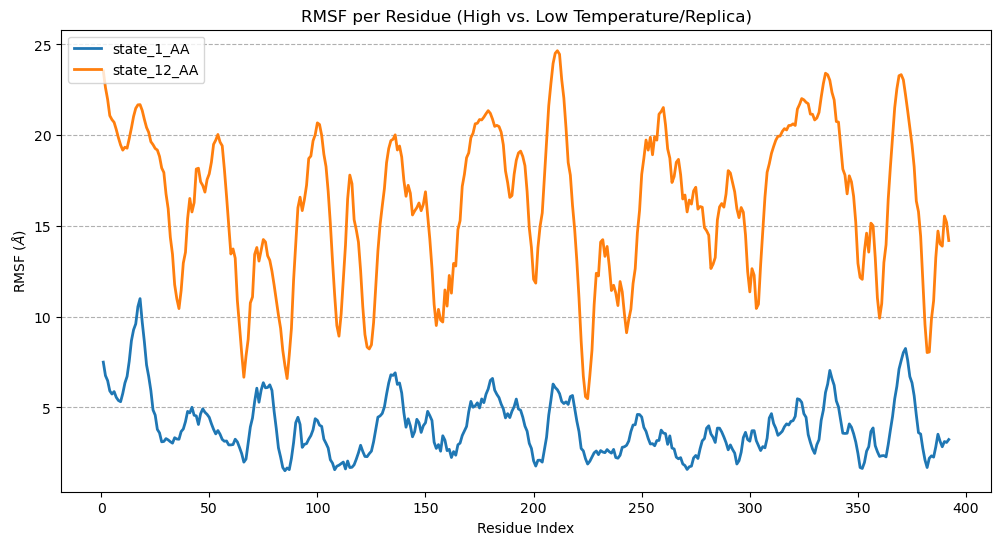

In [50]:
# C. Plot RMSF (Averages over all frames) - Focus on the first few (replica 1 and state 1)
plt.figure(figsize=(12, 6))
# Select key replicas/states for a cleaner plot
plot_tags = [tag for tag in all_rmsf_per_atom.keys()]
# Use only the first few tags if there are too many
if len(all_rmsf_per_atom) > 4:
    plot_tags = [REPLICAS[0].replace(".pdb", ""), REPLICAS[-1].replace(".pdb", ""),
                    STATES[0].replace(".pdb", ""), STATES[-1].replace(".pdb", "")]
    print(plot_tags)
else:
    print(f'Using all tags {plot_tags}')

for tag_full in plot_tags:
    tag = tag_full.split('/')[-1]
    df = all_rmsf_per_atom.get(tag)
    if df is not None and not df.empty:
            # Group RMSF data by Residue ID and take the mean (e.g., C, N, O, CA atoms)
        rmsf_per_residue = df.groupby('Residue_ID')['RMSF'].mean()
        plt.plot(rmsf_per_residue.index, rmsf_per_residue.values, label=tag, linewidth=2)
    else:
        print(f'df missing, tag is {tag}')

plt.title('RMSF per Residue (High vs. Low Temperature/Replica)')
plt.xlabel('Residue Index')
plt.ylabel('RMSF ($\AA$)')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()


In [51]:
# D. Summary Table (Averaged Metrics)
summary_data = []
for tag in all_structural_metrics.keys():
    avg_rmsd = all_rmsd_results[tag]['RMSD'].mean()
    avg_rg = sum(all_structural_metrics[tag]['Rg'])/len(all_structural_metrics[tag]['Rg'])
    avg_q3 = sum(all_structural_metrics[tag]['Q3_Content'])/len(all_structural_metrics[tag]['Q3_Content'])
    avg_e2e = sum(all_structural_metrics[tag]['End_to_End_Distance'])/len(all_structural_metrics[tag]['End_to_End_Distance']) if len(all_structural_metrics[tag]['End_to_End_Distance']) > 0 else np.nan

    # Infer State/Replica number from tag
    temp_metric = "Replica" if "replica" in tag else "State"
    temp_val = int(tag.split('_')[1])

    summary_data.append({
        'Trajectory': tag,
        'Type': temp_metric,
        'Index': temp_val,
        'Avg_RMSD_A': f"{avg_rmsd:.2f}",
        'Avg_Rg_A': f"{avg_rg:.2f}",
        'Avg_Q3_Folded_Fraction': f"{avg_q3:.3f}",
        'Avg_End_to_End_A': f"{avg_e2e:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
# Sort the table by index for easy comparison between high/low temp states/replicas
summary_df_sorted = summary_df.sort_values(by=['Type', 'Index'])

summary_df_sorted["Index"] = pd.to_numeric(summary_df_sorted["Index"])
summary_df_sorted["Avg_RMSD_A"] = pd.to_numeric(summary_df_sorted["Avg_RMSD_A"])
summary_df_sorted["Avg_Rg_A"] = pd.to_numeric(summary_df_sorted["Avg_Rg_A"])
summary_df_sorted["Avg_Q3_Folded_Fraction"] = pd.to_numeric(summary_df_sorted["Avg_Q3_Folded_Fraction"])
summary_df_sorted["Avg_End_to_End_A"] = pd.to_numeric(summary_df_sorted["Avg_End_to_End_A"])

print("\nAverage Structural Metrics Summary:")
print(summary_df_sorted.to_markdown(index=False))

print("\n--- DataFrames Ready ---")
print("The following pandas DataFrames are available for further analysis in your notebook:")
print("1. `all_rmsd_results`: Dictionary of DataFrames with Frame, Time, and RMSD per trajectory.")
print("2. `all_structural_metrics`: Dictionary of DataFrames with Rg, Q3_Content, and Distance per trajectory.")
print("3. `all_rmsf_per_atom`: Dictionary of DataFrames with Residue_ID and RMSF per atom (for RMSF plotting).")
print("4. `summary_df_sorted`: The final summary table of averaged values.")


Average Structural Metrics Summary:
| Trajectory   | Type   |   Index |   Avg_RMSD_A |   Avg_Rg_A |   Avg_Q3_Folded_Fraction |   Avg_End_to_End_A |
|:-------------|:-------|--------:|-------------:|-----------:|-------------------------:|-------------------:|
| state_1_AA   | State  |       1 |        16.43 |      19.05 |                    0.301 |              32.69 |
| state_2_AA   | State  |       2 |        15.35 |      18.03 |                    0.266 |              23.02 |
| state_3_AA   | State  |       3 |        13.59 |      18.78 |                    0.275 |              33.41 |
| state_4_AA   | State  |       4 |        20.42 |      21.56 |                    0.093 |              37.69 |
| state_5_AA   | State  |       5 |        20.04 |      20.85 |                    0.062 |              36.32 |
| state_6_AA   | State  |       6 |        22.12 |      21.32 |                    0.038 |              35.05 |
| state_7_AA   | State  |       7 |        15.49 |      19.58 |    

In [52]:
index_to_temp_map = {1: 200,
                     2: 236,
                     3: 273,
                     4: 309,
                     5: 346,
                     6: 382,
                     7: 418,
                     8: 455,
                     9: 491,
                     10: 527,
                     11: 564,
                     12: 600}
summary_df_sorted['temp'] = summary_df_sorted['Index'].map(index_to_temp_map)

In [53]:
state_summary_df = summary_df_sorted[summary_df_sorted.Type == 'State']
replica_summary_df = summary_df_sorted[summary_df_sorted.Type == 'Replica']

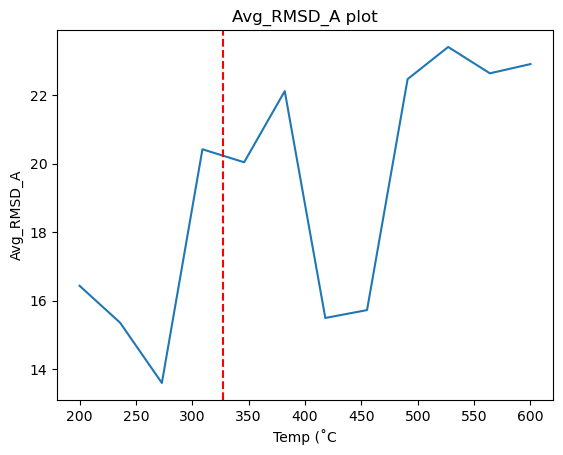

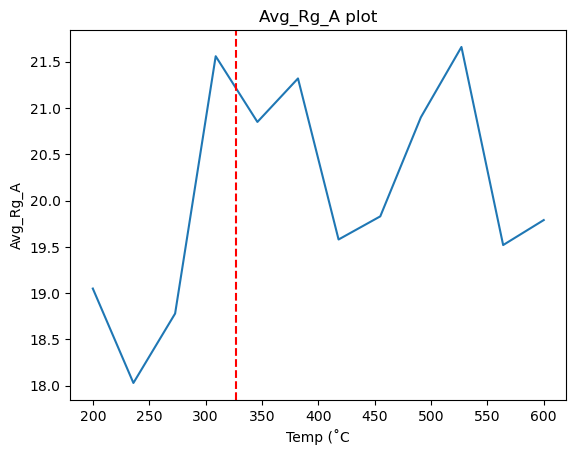

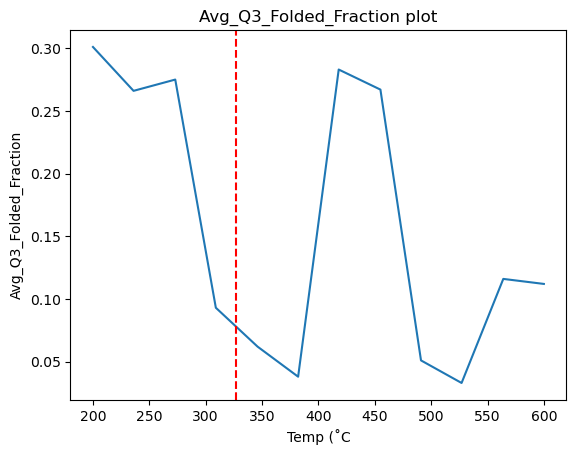

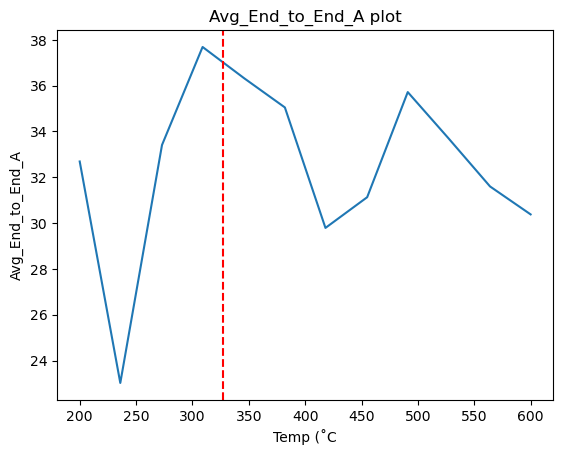

In [ ]:

reference_melt = 327

for factor in ['Avg_RMSD_A', 'Avg_Rg_A', 'Avg_Q3_Folded_Fraction', 'Avg_End_to_End_A']:
    sns.lineplot(state_summary_df, x='temp', y=factor)
    plt.title(f'{factor} plot')
    plt.xlabel('Temp (˚C')
    plt.axvline(reference_melt, c='r', ls='dashed', label ='PRO403 Tm')
    plt.savefig(f'{factor}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [55]:
summary_df_sorted


,Trajectory,Type,Index,Avg_RMSD_A,Avg_Rg_A,Avg_Q3_Folded_Fraction,Avg_End_to_End_A,temp
0,state_1_AA,State,1,16.43,19.05,0.301,32.69,200
1,state_2_AA,State,2,15.35,18.03,0.266,23.02,236
2,state_3_AA,State,3,13.59,18.78,0.275,33.41,273
3,state_4_AA,State,4,20.42,21.56,0.093,37.69,309
4,state_5_AA,State,5,20.04,20.85,0.062,36.32,346
5,state_6_AA,State,6,22.12,21.32,0.038,35.05,382
6,state_7_AA,State,7,15.49,19.58,0.283,29.79,418
7,state_8_AA,State,8,15.72,19.83,0.267,31.13,455
8,state_9_AA,State,9,22.47,20.90,0.051,35.72,491
9,state_10_AA,State,10,23.41,21.66,0.033,33.71,527


In [56]:
import json

summary_df_sorted.to_csv('summary.csv')

# Use pd.concat with the keys argument
rmsd_df = pd.concat(
    all_rmsd_results,
    keys=all_rmsd_results.keys(),  # Use the dictionary keys as the grouping column
    names=['Run', 'Index_Original'] # Name the key column 'Run' and the original index 'Index_Original'
)

# Reset the index to make 'Run' a regular column and keep the original index separate
rmsd_df = rmsd_df.reset_index(level='Run')

rmsd_df.to_csv('rmsd.csv')

with open('structural_metrics.json', 'w') as fp:
    json.dump(all_structural_metrics, fp)
